In [1]:
from maxlen_optimizer import MaxLengthOptimizer
from splitter import DataSplitter
import pandas as pd
import numpy as np

In [2]:
CSV_PATH = "../data/processed/preprocessed_lyrics.csv"
OUTPUT_DIR = "../data/splits"

In [3]:
splitter = DataSplitter(CSV_PATH)
splitter.load_data()
splitter.create_splits(train_size=0.8, val_size=0.1, test_size=0.1)

for split_name in ['train', 'val', 'test']:
    texts, labels = splitter.get_split_for_pytorch(split_name)
    print(f"{split_name.title()} split size: {len(texts)}")
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  Class distribution: {dict(zip(unique, counts))}")
    splitter.compute_class_weights('inverse', use_split=split_name)
    splitter.compute_class_weights('sqrt', use_split=split_name)

total = sum(len(splitter.get_split_for_pytorch(name)[0]) for name in ['train', 'val', 'test'])
print(f"Total samples in splits: {total}")
print(f"Total samples in dataset: {len(splitter.df)}")
assert total == len(splitter.df), "Splits do not cover the whole dataset!"

Loading data from ../data/processed/preprocessed_lyrics.csv
Dataset loaded: 551,398

Emotion distribution in full dataset:
  joy: 209,003 samples (0.379)
  sadness: 171,071 samples (0.310)
  anger: 109,673 samples (0.199)
  fear: 28,096 samples (0.051)
  love: 27,963 samples (0.051)
  surprise: 5,592 samples (0.010)

=== Split Statistics ===
TRAIN SET: 441,118 samples
  joy: 167,202 (0.379)
  sadness: 136,857 (0.310)
  anger: 87,738 (0.199)
  fear: 22,476 (0.051)
  love: 22,371 (0.051)
  surprise: 4,474 (0.010)
VAL SET: 55,140 samples
  joy: 20,900 (0.379)
  sadness: 17,107 (0.310)
  anger: 10,968 (0.199)
  fear: 2,810 (0.051)
  love: 2,796 (0.051)
  surprise: 559 (0.010)
TEST SET: 55,140 samples
  joy: 20,901 (0.379)
  sadness: 17,107 (0.310)
  anger: 10,967 (0.199)
  fear: 2,810 (0.051)
  love: 2,796 (0.051)
  surprise: 559 (0.010)
Train split size: 441118
  Class distribution: {np.int64(0): np.int64(87738), np.int64(1): np.int64(22476), np.int64(2): np.int64(167202), np.int64(3): np

In [4]:
splitter.compute_all_class_weights()

In [5]:
splitter.save_splits(OUTPUT_DIR)

Saved train split: ../data/splits\train.csv (441,118 samples)
Saved val split: ../data/splits\val.csv (55,140 samples)
Saved test split: ../data/splits\test.csv (55,140 samples)
Saved label encoder: ../data/splits\label_encoder.joblib
Saved metadata: ../data/splits\split_metadata.json



| Name             | Train | Val | Test | Use Case/Recommendation                |
|------------------|-------|-----|------|----------------------------------------|
| Standard         | 0.8   | 0.1 | 0.1  |  Maximizing training data, enough for validation and testing. |
| Large validation | 0.7   | 0.2 | 0.1  |  Tuning hyperparameters more thoroughly or need more validation data for early stopping. |
| Large test       | 0.7   | 0.1 | 0.2  |  Estimating more robust model performance. |


In [6]:
def test_max_length_optimization():
    """Test different max_length optimization strategies"""
    print("=" * 60)
    print("TESTING MAX LENGTH OPTIMIZATION")
    print("=" * 60)
    
    coverage_targets = [0.85, 0.90, 0.95, 0.99]
    
    results = {}
    for target in coverage_targets:
        print(f"\n--- Coverage Target: {target*100:.0f}% ---")
        
        optimal_length = MaxLengthOptimizer.get_optimal_max_length(
            CSV_PATH, 
            coverage_target=target,
            verbose=True
        )
        
        results[target] = optimal_length
    
    print(f"\n=== Comparison Summary ===")
    for target, length in results.items():
        memory_factor = length / min(results.values())
        print(f"Coverage {target*100:.0f}%: max_length={length} (memory factor: {memory_factor:.1f}x)")
    
    return results


In [7]:
max_length_results = test_max_length_optimization()

TESTING MAX LENGTH OPTIMIZATION

--- Coverage Target: 85% ---


=== Max Length Analysis ===
Dataset: ../data/processed/preprocessed_lyrics.csv
Samples analyzed: 10000
Mean length: 350.9
95th percentile: 731.0
Target coverage: 85.0%
Optimal max_length: 688
Estimated truncation: ~15.0% of samples

--- Coverage Target: 90% ---
=== Max Length Analysis ===
Dataset: ../data/processed/preprocessed_lyrics.csv
Samples analyzed: 10000
Mean length: 350.5
95th percentile: 752.0
Target coverage: 90.0%
Optimal max_length: 704
Estimated truncation: ~10.0% of samples

--- Coverage Target: 95% ---
=== Max Length Analysis ===
Dataset: ../data/processed/preprocessed_lyrics.csv
Samples analyzed: 10000
Mean length: 350.0
95th percentile: 751.0
Target coverage: 95.0%
Optimal max_length: 832
Estimated truncation: ~5.0% of samples

--- Coverage Target: 99% ---
=== Max Length Analysis ===
Dataset: ../data/processed/preprocessed_lyrics.csv
Samples analyzed: 10000
Mean length: 352.7
95th percentile: 751.0
Target coverage: 99.0%
Optimal max_length: 1024
Estimated truncation: 

In [8]:
def analyze_truncation_with_max_lengths(csv_path, max_length_results, tokenizer=None, sample_size=1000):
    df = pd.read_csv(csv_path)
    texts = df["text"].dropna().tolist()
    texts_sample = texts[:min(sample_size, len(texts))]

    if tokenizer:
        lengths = [len(tokenizer(text, truncation=False, padding=False)['input_ids']) for text in texts_sample]
    else:
        lengths = [len(text.split()) for text in texts_sample]

    print("\n" + "=" * 60)
    print("TRUNCATION ANALYSIS USING max_length_results")
    print("=" * 60)

    for coverage, max_length in max_length_results.items():
        samples_truncated = sum(1 for l in lengths if l > max_length)
        truncation_rate = samples_truncated / len(lengths)
        avg_words_lost = (
            sum(max(0, l - max_length) for l in lengths) / samples_truncated if samples_truncated else 0
        )
        print(f"\nCoverage target: {coverage*100:.0f}%")
        print(f"  Max length: {max_length}")
        print(f"  Truncation rate: {truncation_rate:.1%}")
        print(f"  Samples truncated: {samples_truncated:,}")
        print(f"  Avg words lost per truncated sample: {avg_words_lost:.1f}")

In [9]:
analyze_truncation_with_max_lengths(CSV_PATH, max_length_results, sample_size=50000)


TRUNCATION ANALYSIS USING max_length_results

Coverage target: 85%
  Max length: 688
  Truncation rate: 6.3%
  Samples truncated: 3,132
  Avg words lost per truncated sample: 206.3

Coverage target: 90%
  Max length: 704
  Truncation rate: 5.7%
  Samples truncated: 2,847
  Avg words lost per truncated sample: 210.1

Coverage target: 95%
  Max length: 832
  Truncation rate: 2.4%
  Samples truncated: 1,189
  Avg words lost per truncated sample: 296.2

Coverage target: 99%
  Max length: 1024
  Truncation rate: 0.8%
  Samples truncated: 409
  Avg words lost per truncated sample: 526.6


**Key Results for random sample size = 50000 for LSTM:**

| Coverage Target | Max Length | Truncation Rate | Samples Truncated | Avg Words Lost | Memory Factor |
|-----------------|------------|-----------------|-------------------|----------------|--------------|
| 85%             | 688        | 6.3%            | 3,132             | 206.3          | 1.0x         |
| 90%             | 704        | 5.7%            | 2,847             | 210.1          | 1.0x         |
| **95%**         | **832**    | **2.4%**        | **1,189**         | **296.2**      | **1.2x**     |
| 99%             | 1024       | 0.8%            | 409               | 526.6          | 1.5x         |

**Decision:**  
We will use **max_length = 832** for all splits and model training.  
This setting preserves 95% of samples without truncation, keeps memory usage reasonable, and minimizes information loss.

In [16]:
import vocab_sizing as vs
import pandas as pd

Processed 154429693 tokens, 481144 unique types

Recommended vocab sizes:
  95% coverage -> 6,749 tokens
  97% coverage -> 12,982 tokens
  99% coverage -> 44,228 tokens


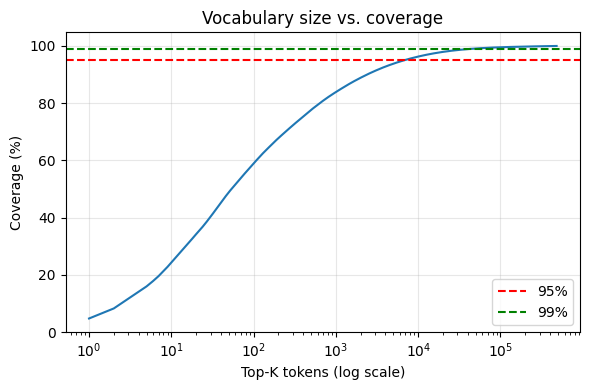

In [17]:
df = pd.read_csv("../data/splits/train.csv")
texts = df["text"].dropna().tolist()

counter, total_tokens = vs.build_freq_counter(texts, max_rows=500000)
print(f"Processed {total_tokens} tokens, {len(counter)} unique types")

results, cum = vs.coverage_analysis(counter, total_tokens)
print("\nRecommended vocab sizes:")
for k, v in results.items():
    print(f"  {k} coverage -> {v:,} tokens")

vs.plot_coverage(cum)

In [18]:
vocab_size = 10000
if vocab_size <= len(cum):
    coverage = cum[vocab_size - 1] * 100  # cum is 0-indexed
    print(f"\nCoverage with top {vocab_size:,} tokens: {coverage:.2f}%")
else:
    print(f"\nVocab size {vocab_size} exceeds total unique tokens ({len(cum)})")


Coverage with top 10,000 tokens: 96.29%
